In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Normalizing Flows for Counterfactual Inference

Authors: Lily Bessette, Vincent Kennedy, Sam Stites

In this tutorial, we will replicate the work of the [Pyro Normalizing Flows Examples](https://pyro.ai/examples/normalizing_flows_i.html) within a PyroModule Framework. The PyroModule Framework will allow us to build a Structural Causal Model that we can perform the typical conditioning and do-calculus operations of on. We will demonstrate how to perform counterfactual inference on this concentric circle toy dataset (defined in donuts.py file). The PyroModule framework demonstrated here will be necessary for the steps of Twin-World Counterfactual Inference Algorithm.

## Table of Contents:
* **Background**
    * Introduction to Normalizing Flows 
    * Twin-World Counterfactual Inference Algorithm
* **Set Up PyroModule Framework**
    * Package Imports
    * Create Dataset 
    * Training Module
    * Flow-Based PyroModule Framework
* **Mirroring Normalizing Flows Pyro Tutorial in PyroModule Framework**
    * Flow-Based Univariate Model
    * Flow-Based Multivariate Model
    * Basic Flow-Based Conditional Model
* **Adding More Complexity to Conditional Models**
    * Basic Conditional Model with One Additional Noise Variable
    * Flow-Based Conditional Model with Continuous Context Variables
* **Implementation of Structural Causal Model with Normalizing Flows and Counterfactual Inference**
    * Conditional Affine Transform 
    * Structural Causal Model for Conditional Distributions
    * Infer Exogenous Variables and Perform Counterfactual Query
    * Plot the Twin World Counterfactual Result

# Background

## Normalizing Flows Basics

A normalizing flow is a kind of neural architecture that transforms some simple (but often high-dimensionsal) noise distribution into a more complex, sometimes high-dimensional distribution. Often the base noise distribution is a Gaussian. We apply this sequence of neural networks in such a way that we obtain a valid probability distribution and can invert the composition of the neural networks. We also require that we can tractably compute the determinant of the Normalizing flow's inverse's Jacobian with respect to the base distribution values. With invertibility and tractable Jacobian computation, we can compute the density of their output exactly using the change of variables formula from vector calculus. We can also exactly recover the value of the base noise distribution sample that generated the flow's output sample.

By way of example, suppose we are interested in modeling a set of pixels (an image) using a normalizing flow that takes samples from a high dimensional isotropic Gaussian as input. Each components of the normalizing flows moves the Gaussian noise in such a way that they noise values don't bump into each other but move toward the desired pixel distribution. We can recover the noise value the generated the image by passing the image through the inverse of the normalizing flow. 

Normalizing flows are useful in cases where we want tractable and efficient computation of noise variables that generate desired output observations. As we will see below, this is precisely what we desire when performing counterfactual inference with structural causal models.

## Twin-World Counterfactual Inference Algorithm

When we have a structural causal model over some set of variables that may be represented in a DAG, we may perform counterfactual inference. Counterfactual inference involves performing three steps:

1. **Abduction** - Predict the ‘state of the world’ (the exogenous noise, $\epsilon$) that is compatible with the observations, X, i.e. infer $P_{G}(\epsilon|x_1,x_2)$.
2. **Action** - Perform an intervention (e.g. $do(factor := \hat{0.1})$) corresponding to the desired manipulation, resulting in a modified SCM: 
$$SCM, \hat{G} = G{(x_1,x_2),do(factor := 0.1)} = (\hat{SCM}, P_{G}(\epsilon$|x_1,x_2)$$
3. **Prediction** - Compute the quantity of interest based on the distribution entailed by the counterfactual SCM, $P_{\hat{G}}(x_1,x_2)$.

Our ability to perform these three steps is usually limited by our ability to do abduction of the exogenous noise variables. With normalizing flows, we can exactly abduct the noise variables that generate outputs modeled by normalizing flows by taking advantage of the invertibility of the normalizing flows. Moreover, we can perform abduction for high dimensional outputs like rich media. Contrast this property of flows with variational autoencoders, which are not usually designed to be invertible or provide efficient inverse Jacobian calculation so require we perform approximate inference of the base noise variable.

## Dataset

While normalizing flows are most powerful in the context of modeling rich media, exploring the basics of applying normalizing flows to an SCM over a simple dataset makes clear the foundations of putting these models into practice. If you can follow along with this tutorial, you will understand the backbone of applying this approach to higher dimensional features.

To that end, we model concentric circles - "donuts" - that are represented by points on the 2D plane, represented by an "x1" value and an "x2" value. We generate these samples from a scikit-learn dataset module. With the make_dataset function, we can generate a variety of concentric circle pairs that vary by how separated they are - a "factor" variable - and how noisy they are - a "noise" variable. 

We construct a DAG over noise, factor, x1 and x2. We then encode this data using a structural causal model so that we may perform counterfactual inference on the model. We will model the mechanisms between these endogenous variables as normalizing flows.

## Flow of the tutorial (pun intended)

This tutorial serves to teach three concepts:
* How to implement a normalizing flow model in pyro
* How to use normalizing flows as mechanisms in an SCM
* How to perform the abduction, action, prediction algorithm for an SCM with normalizing flows mechanisms

To first illustrate how to implement normalizing flows in pyro, we walk through modeling our dataset with the three main classes of flows:
* Univariate flows
* Multivariate flows
* Conditional flows

Then, our tutorial culminates by implementing a full SCM that uses normalizing flows as its mechanisms and implement the counterfactual algorithm. 

# Preliminaries

## Import packages

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import donuts
from donuts import compare, DonutsDataset, plot, smoke_test, sumall, get_logprobs, ConditionalAffineTransform

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
from time import sleep
from tqdm import tqdm, trange
from functools import reduce, partial
import inspect
from operator import itemgetter
from typing import *

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample, pyro_method
from pyro import poutine
import pyro.distributions as dist
import pyro.distributions.transforms as T
from pyro.distributions import constraints
from pyro.distributions import Normal, Bernoulli, TransformedDistribution
from pyro.distributions.torch_transform import ComposeTransformModule
from pyro.distributions.conditional import ConditionalTransformModule, ConditionalTransformedDistribution
from pyro.infer.reparam.transform import TransformReparam
import pyro.distributions.transforms as T
from pyro.distributions.transforms import ComposeTransform, SigmoidTransform, AffineTransform
from pyro.distributions import constraints
from pyro.nn import DenseNN
from pyro.distributions.torch_transform import ComposeTransformModule
from pyro.nn import DenseNN

import torch
from torch.distributions import Independent
from torch.optim import Adam
from torch import tensor, sigmoid
from torch.distributions.transforms import AffineTransform
import torch.distributions.transforms as TT
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn.init as init

In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Create Dataset

Set the seed, smoke_test on/off, number of samples for the data, and set up the visualize function from donuts.py.

In [18]:
pyro.set_rng_seed(1)
is_smoke_test = False
n_samples = 1000
dataset =  DonutsDataset(n_samples=n_samples, hole=None, noise=0.01, factor=0.3)
visualize=partial(donuts.visualize, dataset)

## Training Module

##### Standard Training Loop

Using our generative model, we use our observed data to condition the model on the data and extract a trace from the conditioned model. The built in functionality of a PyroModule is used to compute the log probabilities over the trace output. Then, the log probabilities are extracted over the specified observed values (i.e. over_vars). The element-wise sum is taken and then the mean is calculated. The loss is stored as the negative of this value and is minimized for optimization. 

The main nuance from a standard training loop in an normalizing flows setting is the clearing of the cache of the model's stateful flow variables at each optimization step.

Documentation:  [Adam Optimizer](http://docs.pyro.ai/en/0.3.0-release/optimization.html#pyro.optim.pytorch_optimizers.Adam) ,  [Optimizer](https://pytorch.org/docs/stable/optim.html)

In [19]:
def train(model, over_vars, dataset=dataset, n_epochs=500, lr=3e-3, n_samples=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    x1, x2 = [dataset.data[x] for x in ['x1', 'x2']]
    dataset.data['x1_x2'] = torch.cat([x1, x2], dim=-1)  # for univariates
    losses = []
    with trange(n_epochs) as epoch_reporter:
        for step in epoch_reporter:
            optimizer.zero_grad()
            cond_model = pyro.condition(model.model, data=dataset.data)
            model_trace = poutine.trace(cond_model).get_trace()
            model_trace.compute_log_prob()
            loss = -sumall(map(partial(get_logprobs, model_trace), over_vars)).mean()
            loss.backward()
            optimizer.step()
            epoch_reporter.set_postfix_str('loss: {:.6f}'.format(loss.detach()))
            model.clear_cache()
    return losses

## Flow-Based PyroModule Framework

We build a base class that inherits from PyroModule and contains several methods that will be reused across the progressively more fulsome versions of the model. 

Important notes on implementation of flows based learning in this PyroModule Framework:
* Registering Buffers is needed for the Flows to train on a stable latent space.
* This will be training a transformed distribution instead of training the distribution directly.
* This transformed distribution is an Affine Transformation.

In [20]:
class FlowBased(PyroModule):
    def __init__(self, verbose=True):
        super().__init__()
        self._register_buffers()
        self._build_flow()
 
    def build_flow(self):
        raise NotImplementedError()

    def _build_flow(self):
        self.flow_states = []
        before = set(dir(self))
        self.build_flow()
        after = set(dir(self))
        # FIXME: should also add an instance check
        self.flow_states = [getattr(self, new) for new in after - before]
        if len(self.flow_states) == 0:
            print("[WARNING] No flow states registered in self.flow_states after self._build_flow()")

    def register_buffers(self):
        return dict()

    def _register_buffers(self):
        pairs = self.register_buffers()
        for name, tensor in pairs.items():
            assert tensor.requires_grad is not True, f"{name} shouldn't be in autograd"
            self.register_buffer(name, tensor)

    def clear_cache(self):
        for flow in self.flow_states:
            try:
                flow.clear_cache()
            except:
                pass

# Tutorial on Normalizing Flows in Pyro: Mirroring Normalizing Flows Pyro Tutorial in PyroModule Framework

The following is an application of the [Learnable Univariate Distribution (Pyro Example)](https://pyro.ai/examples/normalizing_flows_i.html#Univariate-Distributions) in this new PyroModule Framework.

## Flow-Based Univariate Model

We first model the marginals of x1 and x2 as univariate distributions, parametrized by univariate normalizing flows.

(tensor(-1.5443, grad_fn=<SelectBackward>), tensor(-1.0416, grad_fn=<SelectBackward>))
torch.Size([13])


100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.19it/s, loss: 1.078516]


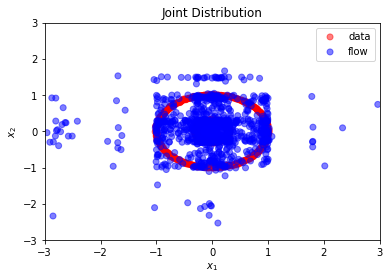

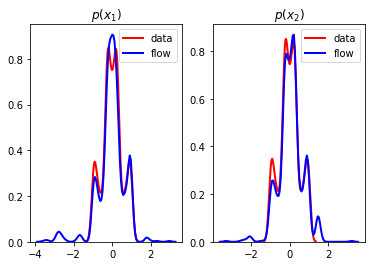

Wall time: 9.03 s


In [24]:
%%time
class UnivariateModel(FlowBased):
    def __init__(self):
        super().__init__()
        # NOTE: Flows require a stable latent to target. Thus we don't put these on the computation graph.
        self.register_buffer('loc', torch.zeros([2], requires_grad=False))
        self.register_buffer('scale', torch.ones([2], requires_grad=False))

    def build_flow(self):
        self.spline_transform = T.Spline(2, count_bins=16)

    def model(self):
        dist_base = dist.Normal(self.loc, self.scale)
        flow_dist = dist.TransformedDistribution(dist_base, [self.spline_transform])
        xs = pyro.sample('x1_x2', flow_dist.to_event(1))
        # account for batching
        return (xs[:,0], xs[:,1]) if len(xs.shape) == 2 else (xs[0], xs[1])

model = UnivariateModel()
smoke_test(model)

losses = train(model, n_epochs=1 if is_smoke_test else 5000, n_samples=1000, over_vars=['x1_x2'])
visualize(model)

We can see this univariate distribution model captures the marginal distributions of x1 and x2 reasonably well but fails to capture the joint distribution, which is what we care about.

## Flow-Based Multivariate Model

The following is an application of the [Multivariate Distribution Transforms (Pyro Example)](https://pyro.ai/examples/normalizing_flows_i.html#Multivariate-Distributions) in this new PyroModule Framework.

We then model the joint distribution of x1 and x2 using a multivariate normalizing flow. 

(tensor(-0.8589, grad_fn=<SelectBackward>), tensor(0.1713, grad_fn=<SelectBackward>))
torch.Size([13])


100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.24it/s, loss: 0.525668]


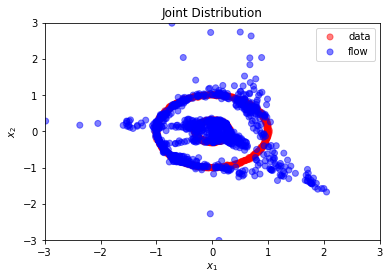

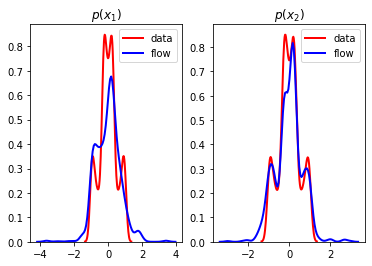

Wall time: 19.2 s


In [25]:
%%time

class MultivariateModel(FlowBased):
    def __init__(self):
        super().__init__()
        self.register_buffer('loc', torch.zeros([2], requires_grad=False))
        self.register_buffer('scale', torch.ones([2], requires_grad=False))

    def build_flow(self):
        self.spline_transform = T.spline_coupling(2, count_bins=16)

    def model(self):
        dist_base = dist.Normal(self.loc, self.scale)
        flow_dist = dist.TransformedDistribution(dist_base, [self.spline_transform])
        xs = pyro.sample('x1_x2', flow_dist)
        # account for batching
        return (xs[:,0], xs[:,1]) if len(xs.shape) == 2 else (xs[0], xs[1])

model = MultivariateModel()
smoke_test(model)

losses = train(model, n_epochs=1 if is_smoke_test else 5000, n_samples=1000, over_vars=['x1_x2'])
visualize(model)

We can see this model captures both the marginal distributions and the joint distributions much better than the univariate model.

## Basic Flow-Based Conditional Model

The following is an application of the [Conditional Distribution Transforms (Pyro Example)](https://pyro.ai/examples/normalizing_flows_i.html#Conditional-versus-Joint-Distributions) in this new PyroModule Framework. 

Finally, we show how to model the joint distribution using the conditional factorization of the joint distribution of $p(x1, x2) = p(x1)p(x2|x1)$. Understanding this implementation is key for using normalizing flows as mechanisms in SCMs, even if it does not necessarily yield any inherent performance advantage in modeling just the joint distribution of x1 and x2.

(tensor([-1.0936], grad_fn=<IndexPutBackward>), tensor([-1.5341], grad_fn=<IndexPutBackward>))
torch.Size([13, 1])


100%|█████████████████████████████████████████████████████████████| 5000/5000 [01:27<00:00, 57.33it/s, loss: -0.764374]


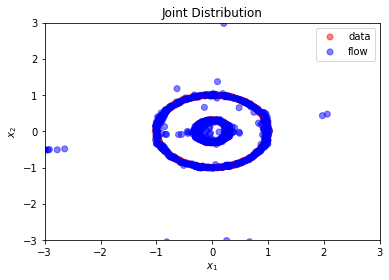

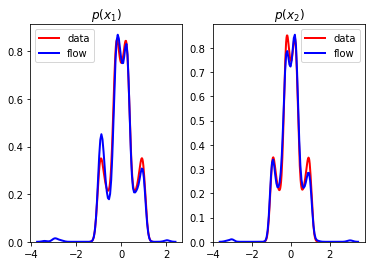

Wall time: 1min 28s


In [26]:
%%time
class ConditionalModel(FlowBased):
    def __init__(self):
        super().__init__()
        # NOTE: Flows require a stable latent to target. Thus we don't put these on the computation graph.
        self.register_buffer('loc', torch.zeros([1], requires_grad=False))
        self.register_buffer('scale', torch.ones([1], requires_grad=False))

    def build_flow(self):
        self.x1_transform = T.spline(1)
        self.x2_transform = T.conditional_spline(1, context_dim=1)   # placed in parameters

    def model(self):
        dist_base = dist.Normal(self.loc, self.scale)
        dist_x1 = dist.TransformedDistribution(dist_base, [self.x1_transform])
        dist_x2_given_x1 = dist.ConditionalTransformedDistribution(dist_base, [self.x2_transform])
        x1 = pyro.sample('x1', dist_x1.to_event(1))
        x2 = pyro.sample('x2', dist_x2_given_x1.condition(x1.detach()).to_event(1))
        return x1, x2

model = ConditionalModel()
smoke_test(model)

losses = train(model, over_vars=['x1', 'x2'], n_epochs=(1 if is_smoke_test else 5000), n_samples=1000)
if not is_smoke_test:
    visualize(model)

# Bridge to SCM: Adding More Complexity to Conditional Models

Before diving into the full SCM, we first demonstrate how we can extend our conditioning set to include more context variables. The intent of this step in the tutorial is to make clear this extension without getting bogged down in some other implementation nuances that will come with the full SCM and the methods that will implement the abduct-act-predict counterfactual algorithm.

Note: we expect no performance improvement over our models above because the context variables are not varied by datapoint.

## Basic Conditional Model with Additional Noise Variable

(tensor([0.5063], grad_fn=<IndexPutBackward>), tensor([-0.2406], grad_fn=<IndexPutBackward>))
torch.Size([13, 1])


100%|██████████████████████████████████████████████████████████████| 5000/5000 [01:40<00:00, 49.58it/s, loss: 0.842402]


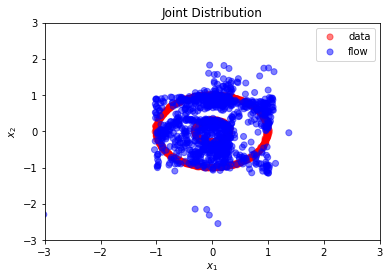

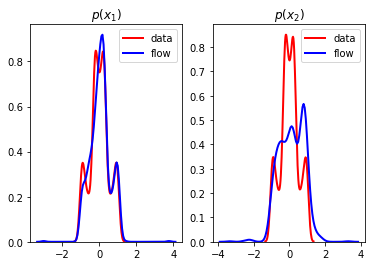

In [27]:
class NoiseModel(FlowBased):
    def __init__(self):
        super().__init__()

    def build_flow(self):
        self.register_buffer('noise_base_loc', torch.zeros([1], requires_grad=False))
        self.register_buffer('noise_base_scale', torch.ones([1], requires_grad=False))
        self.noise_flow_lognorm = AffineTransform(loc=self.noise_base_loc.item(), scale=self.noise_base_scale.item())
        self.x1_transform = T.conditional_spline(1, context_dim=1)
        self.x2_transform = T.conditional_spline(1, context_dim=2)   # placed in parameters

    def model(self):
        noise_base_dist = dist.Normal(self.noise_base_loc, self.noise_base_scale)
        dist_noise = dist.TransformedDistribution(noise_base_dist, [self.noise_flow_lognorm])

        dist_x1_given_noise = dist.ConditionalTransformedDistribution(dist_noise, [self.x1_transform])
        dist_x2_given_noise = dist.ConditionalTransformedDistribution(dist_noise, [self.x2_transform])

        noise = pyro.sample('noise', dist_noise.to_event(1))
        x1 = pyro.sample('x1', dist_x1_given_noise.condition(noise.detach()).to_event(1))
        ctx = torch.cat([noise.detach(), x1.detach()], dim=-1)
        x2 = pyro.sample('x2', dist_x2_given_noise.condition(ctx).to_event(1))
        return x1, x2

model = NoiseModel()
smoke_test(model)

losses = train(model, over_vars=['x1', 'x2', 'noise'], n_epochs=(1 if is_smoke_test else 5000), n_samples=1000)
if not is_smoke_test:
    visualize(model)

## Flow-Based Conditional Model with Continuous Context Variables

(tensor([2.6555], grad_fn=<IndexPutBackward>), tensor([1.6493], grad_fn=<IndexPutBackward>))
torch.Size([13, 1])


100%|████████████████████████████████████████████████████████████| 10000/10000 [04:02<00:00, 41.32it/s, loss: 1.250129]


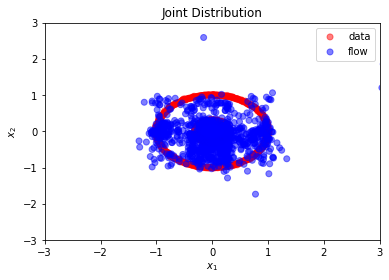

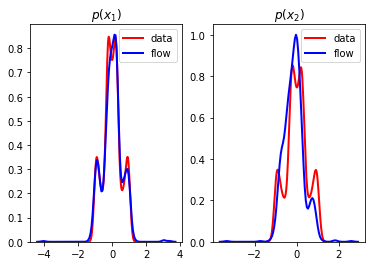

In [28]:
class ContinuousModel(FlowBased):
    def __init__(self):
        super().__init__()
        #self.label_logits = torch.nn.Parameter(torch.zeros([1, ]))

    def register_buffers(self):
        return dict(
            x1_base_loc=torch.zeros([1]),     x1_base_scale=torch.ones([1]),
            x2_base_loc=torch.zeros([1]),     x2_base_scale=torch.ones([1]),
            noise_base_loc=torch.zeros([1]),  noise_base_scale=torch.ones([1]),
            factor_base_loc=torch.zeros([1]), factor_base_scale=torch.ones([1]),
        )

    def build_flow(self):
        self.x1_flow_lognorm = AffineTransform(loc=self.x1_base_loc.item(), scale=self.x1_base_scale.item())
        self.x2_flow_lognorm = AffineTransform(loc=self.x2_base_loc.item(), scale=self.x2_base_scale.item())
        self.noise_flow_lognorm = AffineTransform(loc=self.noise_base_loc.item(), scale=self.noise_base_scale.item())
        self.factor_flow_lognorm = AffineTransform(loc=self.factor_base_loc.item(), scale=self.factor_base_scale.item())

        self.x1_transform = T.conditional_spline(1, context_dim=2, count_bins=16)
        self.x2_transform = T.conditional_spline(1, context_dim=3, count_bins=16)   # placed in parameters

    def model(self):
        x1_base_dist = dist.Normal(self.x1_base_loc, self.x1_base_scale)
        dist_x1 = dist.TransformedDistribution(x1_base_dist, [self.x1_flow_lognorm])

        x2_base_dist = dist.Normal(self.x2_base_loc, self.x2_base_scale)
        dist_x2 = dist.TransformedDistribution(x2_base_dist, [self.x2_flow_lognorm])

        noise_base_dist = dist.Normal(self.noise_base_loc, self.noise_base_scale)
        dist_noise = dist.TransformedDistribution(noise_base_dist, [self.noise_flow_lognorm])

        factor_base_dist = dist.Normal(self.factor_base_loc, self.factor_base_scale)
        dist_factor = dist.TransformedDistribution(factor_base_dist, [self.factor_flow_lognorm])

        cond_dist_x1 = dist.ConditionalTransformedDistribution(dist_x1, [self.x1_transform])
        cond_dist_x2 = dist.ConditionalTransformedDistribution(dist_x2, [self.x2_transform])

        noise = pyro.sample('noise', dist_noise.to_event(1))
        factor = pyro.sample('factor', dist_factor.to_event(1))
        ctx1 = torch.cat([noise.detach(), factor.detach()], dim=-1)
        x1 = pyro.sample('x1', cond_dist_x1.condition(ctx1).to_event(1))

        ctx2 = torch.cat([ctx1.detach(), x1.detach()], dim=-1)
        x2 = pyro.sample('x2', cond_dist_x2.condition(ctx2).to_event(1))
        return x1, x2

model = ContinuousModel()
smoke_test(model)

losses = train(model, over_vars=['x1', 'x2', 'noise', 'factor'], n_epochs=(1 if is_smoke_test else 10000), n_samples=1000)
if not is_smoke_test:
    visualize(model)

# Implementation of Structural Causal Model with Normalizing Flows and Counterfactual Inference

We now implement the following SCM using normalizing flow mechanisms. Note: grey shaded nodes represent latent exogenous noise variables, and white nodes represent endogenous variables.

<img src="..\fig\counterfactual donuts scm.png">

## Structural Causal Model for Conditional Distributions

Now we implement our full SCM, which is very similar to the above expanded conditional flows tutorial. The key additions are:
1. A probabilistic graphical model between the endogenous circle parameters, noise and factor
2. An infer_exogenous method the performs abduction for our exogenous noise variables
3. An scm method that reparametrizes our model to enables conditioning the base distributions of the exogenous variables, which are not explicitly named in pyro.sample statements
3. A counterfactual method that leverages our abduction method, scm method, and pyro's do and condition operators to act on the model and condition on the exegenous noise values to sample forward from the counterfactual distribution. 

In [32]:
class ContinuousSCMModel(FlowBased):
    def __init__(self):
        super().__init__()

    def register_buffers(self):
        return dict(
            x1_base_loc=torch.zeros([1]),     x1_base_scale=torch.ones([1]),
            x2_base_loc=torch.zeros([1]),     x2_base_scale=torch.ones([1]),
            noise_base_loc=torch.zeros([1]),  noise_base_scale=torch.ones([1]),
            factor_base_loc=torch.zeros([1]), factor_base_scale=torch.ones([1]),
            noise_flow_norm_loc=torch.zeros([1]), noise_flow_norm_scale=torch.ones([1]),
            factor_flow_norm_loc=torch.zeros([1]), factor_flow_norm_scale=torch.ones([1]),
        )

    def build_flow(self):
        self.x1_flow_lognorm = AffineTransform(loc=self.x1_base_loc.item(), scale=self.x1_base_scale.item())
        self.x2_flow_lognorm = AffineTransform(loc=self.x2_base_loc.item(), scale=self.x2_base_scale.item())
        self.noise_flow_lognorm = AffineTransform(loc=self.noise_base_loc.item(), scale=self.noise_base_scale.item())
        self.factor_flow_lognorm = AffineTransform(loc=self.factor_base_loc.item(), scale=self.factor_base_scale.item())

        self.x1_transform = T.conditional_spline(1, context_dim=2, count_bins=16)
        self.x2_transform = T.conditional_spline(1, context_dim=3, count_bins=16)   # placed in parameters

        # parametrizes the noise flow base distribution
        self.noise_flow_norm = AffineTransform(loc=self.noise_flow_norm_loc.item(), scale=self.noise_flow_norm_scale.item())

        # parametrizes the factor flow base distribution
        self.factor_flow_norm = AffineTransform(loc=self.factor_flow_norm_loc.item(), scale=self.factor_flow_norm_scale.item())

        # flow for modeling noise
        self.noise_spline, self.noise_sigmoid = T.Spline(1), SigmoidTransform()
        self.noise_flow_components = ComposeTransformModule([self.noise_spline])
        self.noise_flow_constraint_transforms = ComposeTransform([self.noise_flow_norm, self.noise_sigmoid])
        self.noise_flow_transforms = ComposeTransform([self.noise_flow_components, self.noise_flow_constraint_transforms])
        
        # flow for modeling factor variable, conditioned on the noise value
        factor_net = DenseNN(1, [1], param_dims=[1, 1], nonlinearity=nn.Identity())
        self.factor_flow_components = ConditionalAffineTransform(context_nn=factor_net, event_dim=0)
        self.factor_sigmoid = SigmoidTransform()
        self.factor_flow_constraint_transforms = ComposeTransform([self.factor_flow_norm, self.factor_sigmoid])
        self.factor_flow_transforms = [self.factor_flow_components, self.factor_flow_constraint_transforms]

    def pgm_model(self):
        # create noise distribution
        noise_base_dist = dist.Normal(self.noise_base_loc, self.noise_base_scale).to_event(1) # FIXME
        self.noise_dist = dist.TransformedDistribution(noise_base_dist, self.noise_flow_transforms)
        
        # sample noise value
        noise = pyro.sample('noise', self.noise_dist)
        noise_ = self.noise_flow_constraint_transforms.inv(noise) # transformed version of N_noise
        # pseudo call to noise_flow_transforms to register with pyro
        _ = self.noise_flow_components
        
        # create factor distribution
        factor_base_dist = dist.Normal(self.factor_base_loc, self.factor_base_scale).to_event(1)
        self.factor_dist = dist.ConditionalTransformedDistribution(base_dist=factor_base_dist, transforms=self.factor_flow_transforms).condition(noise_)
        
        # sample factor value
        factor = pyro.sample('factor', self.factor_dist)
        # psuedo call to factor_flow_components to register with pyro
        _ = self.factor_flow_components

        return noise, factor

    def model(self):
        noise, factor = self.pgm_model()

        x1_base_dist = dist.Normal(self.x1_base_loc, self.x1_base_scale)
        dist_x1 = dist.TransformedDistribution(x1_base_dist, [self.x1_flow_lognorm])

        x2_base_dist = dist.Normal(self.x2_base_loc, self.x2_base_scale)
        dist_x2 = dist.TransformedDistribution(x2_base_dist, [self.x2_flow_lognorm])

        cond_dist_x1 = dist.ConditionalTransformedDistribution(dist_x1, [self.x1_transform])
        cond_dist_x2 = dist.ConditionalTransformedDistribution(dist_x2, [self.x2_transform])

        ctx1 = torch.cat([noise.detach(), factor.detach()], dim=-1)
        x1 = pyro.sample('x1', cond_dist_x1.condition(ctx1).to_event(1))

        ctx2 = torch.cat([ctx1.detach(), x1.detach()], dim=-1)
        x2 = pyro.sample('x2', cond_dist_x2.condition(ctx2).to_event(1))
        return x1, x2, noise, factor

    def infer_exogenous(self, **obs):
        cond_sample = pyro.condition(self.model, data=obs)
        cond_trace = poutine.trace(cond_sample).get_trace()

        output = {}
        for name, node in cond_trace.nodes.items():
            if 'fn' not in node.keys():
                continue

            fn = node['fn']
            if isinstance(fn, Independent):
                fn = fn.base_dist
            if isinstance(fn, TransformedDistribution):
                output[name + '_base'] = ComposeTransform(fn.transforms).inv(node['value'])
        return output
    
    def counterfactual(self, obs, condition=None):
        exogenous = self.infer_exogenous(**obs)
        counter = poutine.do(poutine.condition(self.scm, data=exogenous), data=condition)()
        return {k: v for k, v in zip(( 'x1', 'x2', 'noise', 'factor'), counter)}
    
    @pyro_method
    def scm(self, *args, **kwargs):
        def config(msg):
            if isinstance(msg['fn'], TransformedDistribution):
                return TransformReparam()
            else:
                return None

        return pyro.poutine.reparam(self.model, config=config)(*args, **kwargs)
    
    @pyro_method
    def sample_scm(self, n_samples=1):
        with pyro.plate('observations', n_samples):
            samples = self.scm()

        return (*samples,)

model = ContinuousSCMModel()
smoke_test(model)

is_smoke_test = False
losses = train(model, over_vars=['x1', 'x2', 'noise', 'factor'], n_epochs=(1 if is_smoke_test else 5000), n_samples=1000)

(tensor([-0.6827], grad_fn=<IndexPutBackward>), tensor([-0.2178], grad_fn=<IndexPutBackward>), tensor([0.2205], grad_fn=<ClampBackward>), tensor([0.0494], grad_fn=<ClampBackward>))
torch.Size([13, 1])


100%|█████████████████████████████████████████████████████████████| 5000/5000 [02:35<00:00, 32.23it/s, loss: -0.396670]


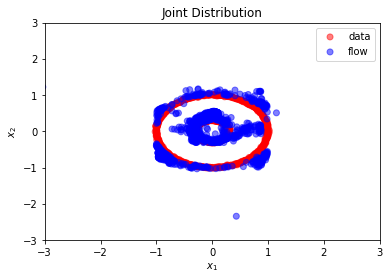

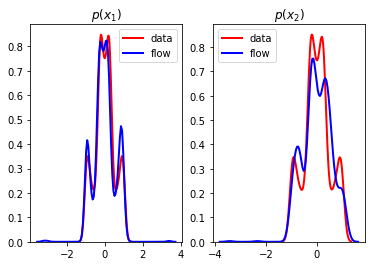

In [33]:
visualize(model)

# Twin-World Counterfactual Inference Algorithm

### Infer Exogenous Variables and Perform Counterfactual Query

In the abduction-action-inference algorithm, we use our variables X1 and X2 (sample) in the current world to infer the exogenous noise variables (i.e. conditions that lead to this sample). Then, we condition our model on these exogenous noise variables to propogate these conditions into this twin world and subsequently mutilate our model with a do operation under the specified counterfactual condition (i.e. factor = 0.1) to forward simulate the twin world alternatives X1' and X2' under this new counterfactual distribution. 

In [34]:
with torch.no_grad():
    model_trace = poutine.trace(model.model).get_trace()
    sample = {k: model_trace.nodes[k]['value'] for k in  ['factor', 'noise', 'x1', 'x2']}
    print(sample)
    print(model.infer_exogenous(**sample))
    print(model.counterfactual(obs=sample, condition=dict(factor=torch.tensor([0.1]))))
    
    many = [model.counterfactual(obs=sample, condition=dict(factor=torch.tensor([0.1]))) for _ in range(1000)]

{'factor': tensor([0.5152]), 'noise': tensor([0.8574]), 'x1': tensor([0.0727]), 'x2': tensor([0.4274])}
{'noise_base': tensor([0.1646]), 'factor_base': tensor([-0.4158]), 'x1_base': tensor([0.2603]), 'x2_base': tensor([-0.9854])}
{'x1': tensor([0.0435]), 'x2': tensor([0.3340]), 'noise': tensor([0.8574]), 'factor': tensor([0.1000])}


## Plot the Twin World Counterfactual Result

For the counterfactual twin world, we performed the $do(factor := \hat{0.1})$ mutilation and in our resulting forward simulated x1,x2 alternatives we see below that the factor between the two circles change in accordance from our change in factor from 0.3 to 0.1 in comparison of the above and below images.

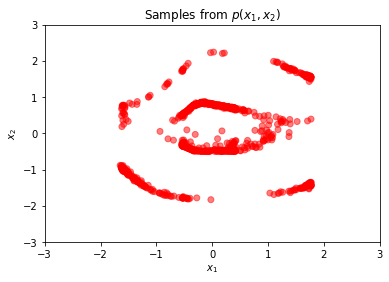

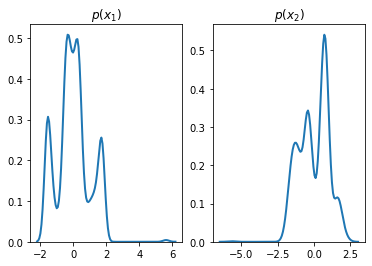

In [35]:
X = torch.stack(list(map(lambda x: torch.cat([x['x1'], x['x2']]), many)))
plot(X[:,0].view(-1,1), X[:,1].view(-1,1), torch.ones_like(X[:,1]).view(-1,1))

# Resources
* https://pyro.ai/examples/normalizing_flows_i.html#Conditional-versus-Joint-Distributions
* http://pyro.ai/examples/tensor_shapes.html
* http://docs.pyro.ai/en/stable/distributions.html#transforms
* https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html
* https://pytorch.org/docs/master/optim.html#torch.optim.Optimizer
* https://readthedocs.org/projects/pyro-ppl/downloads/pdf/stable/
* https://arxiv.org/pdf/2006.06485.pdf
* https://github.com/biomedia-mira/deepscm
* http://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.transforms.SplineCoupling